## Stock Return Prediction

In this case study we will use various supervised learning-based models to predict the
stock price of Microsoft using correlated assets and its own historical data.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)    
    * [4.2.Feature Selection](#3.2)
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
        * [5.3.1 Machine Learning models-scikit-learn](#4.3.1)
        * [5.3.2 Time Series based Models-ARIMA and LSTM](#4.3.2)
* [6. Model Tuning and grid search](#5)
* [7. Finalise the model](#6)
    * [7.1. Result on the test dataset](#6.1)
    * [7.2. Save Model for Later Use](#6.2)     

<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, weekly return of the
Microsoft stock is the predicted variable. We need to understand what affects Microsoft stock price and hence incorporate as much information into the model.

For this case study, other than the historical data of Microsoft, the independent variables used are the following potentially correlated assets:
* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [5]:
import talib as ta

In [6]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web # type: ignore
import yfinance as yf

from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# For Feature Engineering
# import talib as ta

#Libraries for Deep Learning Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LSTM

# This code is no longer apply to TensorFlow 2.6
# from keras.wrappers.scikit_learn import KerasRegressor
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor


#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


In [7]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Set global seed
np.random.seed(7)

<a id='1.2'></a>
## 2.2. Loading the Data

Next, we extract the data required for our analysis using pandas datareader.

In [9]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL'] #Google has too many NAN value
# stk_tickers = ['MSFT', 'IBM', 'AAPL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

start = ccy_data.index[0]; end = ccy_data.index[-1]
stk_data = yf.download(stk_tickers, start, end)

[*********************100%***********************]  3 of 3 completed


Next, we need a series to predict. We choose to predict using weekly returns. We approximate this by using 5 business day period returns.

In [10]:
return_period = 5

We now define our Y series and our X series

Y: MSFT **Future** Returns

X:

    a. GOOGL 5 Business Day Returns
    b. IBM 5 Business DayReturns    
    c. USD/JPY 5 Business DayReturns    
    d. GBP/USD 5 Business DayReturns    
    e. S&P 500 5 Business DayReturns    
    f. Dow Jones 5 Business DayReturns    
    g. MSFT 5 Business Day Returns    
    h. MSFT 15 Business Day Returns    
    i. MSFT 30 Business Day Returns    
    j. MSFT 60 Business Day Returns

We remove the MSFT past returns when we use the Time series models.

In [11]:
stk_data

Price        Adj Close                               Close              \
Ticker           GOOGL         IBM        MSFT       GOOGL         IBM   
Date                                                                     
2019-12-12   67.180962  102.522102  146.571869   67.424500  129.369019   
2019-12-13   67.100258  101.681152  147.805664   67.343498  128.307846   
2019-12-16   67.789268  101.620514  148.762177   68.035004  128.231354   
2019-12-17   67.499809  101.688705  147.958710   67.744499  128.317398   
2019-12-18   67.351349  101.832649  147.652634   67.595497  128.499039   
...                ...         ...         ...         ...         ...   
2024-11-29  168.756592  227.410004  423.459991  168.949997  227.410004   
2024-12-02  171.293686  227.389999  430.980011  171.490005  227.389999   
2024-12-03  171.143845  229.000000  431.200012  171.339996  229.000000   
2024-12-04  174.170380  233.490005  437.420013  174.369995  233.490005   
2024-12-05  172.442368  234.750000  442.619995  172.639999  234.750000   

Price                         High                                 Low  \
Ticker            MSFT       GOOGL         IBM        MSFT       GOOGL   
Date                                                                     
2019-12-12  153.240005   67.728996  129.694077  153.440002   66.910004   
2019-12-13  154.529999   67.567497  129.541107  154.889999   67.083000   
2019-12-16  155.529999   68.176498  129.493301  155.899994   67.530502   
2019-12-17  154.690002   68.216499  128.766724  155.710007   67.538498   
2019-12-18  154.369995   67.971497  129.063095  155.479996   67.523003   
...                ...         ...         ...         ...         ...   
2024-11-29  423.459991  169.429993  230.360001  424.880005  167.160004   
2024-12-02  430.980011  172.080002  228.380005  433.000000  168.570007   
2024-12-03  431.200012  172.679993  229.110001  432.470001  170.850006   
2024-12-04  437.420013  174.910004  233.740005  439.670013  171.059998   
2024-12-05  442.619995  176.059998  236.520004  444.660004  172.330002   

Price                                     Open                          \
Ticker             IBM        MSFT       GOOGL         IBM        MSFT   
Date                                                                     
2019-12-12  127.782028  151.020004   67.160500  127.820267  151.649994   
2019-12-13  128.116638  152.830002   67.394997  128.824097  153.000000   
2019-12-16  127.963669  154.820007   67.750000  129.005737  155.110001   
2019-12-17  127.590820  154.449997   68.120499  128.374756  155.449997   
2019-12-18  128.250473  154.179993   67.849998  128.632889  154.300003   
...                ...         ...         ...         ...         ...   
2024-11-29  227.190002  417.799988  168.500000  227.750000  420.089996   
2024-12-02  225.509995  421.309998  168.770004  227.500000  421.570007   
2024-12-03  226.669998  427.739990  171.490005  227.240005  429.839996   
2024-12-04  229.350006  432.630005  171.149994  230.000000  433.029999   
2024-12-05  233.460007  436.170013  175.360001  233.550003  437.920013   

Price         Volume                     
Ticker         GOOGL      IBM      MSFT  
Date                                     
2019-12-12  29114000  5046009  24612100  
2019-12-13  33170000  2651610  23845400  
2019-12-16  28128000  3189463  24144200  
2019-12-17  32948000  3040931  25425600  
2019-12-18  23330000  3244483  24129200  
...              ...      ...       ...  
2024-11-29  14257200  2640300  16271900  
2024-12-02  23789100  2655900  20207200  
2024-12-03  22248700  3163800  18302000  
2024-12-04  31615100  4104200  26009400  
2024-12-05  21356200  4791100  21697800  

[1254 rows x 18 columns]

In [12]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

In [13]:
# Create multiple indicators first then evaluate the predictive power of the indicators

# Generate Features (Technical Indicators)
features = pd.DataFrame(index=stk_data.index)  # Empty DataFrame to store features

# MSFT-specific indicators
# Relative Strength Index (RSI)
features['MSFT_RSI'] = ta.RSI(stk_data.loc[:, ('Adj Close', 'MSFT')], timeperiod=14)

# Moving Average Convergence Divergence (MACD)
features['MSFT_MACD'], features['MSFT_MACD_signal'], features['MSFT_MACD_hist'] = ta.MACD(
    stk_data.loc[:, ('Adj Close', 'MSFT')], fastperiod=12, slowperiod=26, signalperiod=9)

# Bollinger Bands
features['MSFT_BB_upper'], features['MSFT_BB_middle'], features['MSFT_BB_lower'] = ta.BBANDS(
    stk_data.loc[:, ('Adj Close', 'MSFT')], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# Average True Range (ATR)
features['MSFT_ATR'] = ta.ATR(
    stk_data.loc[:, ('High', 'MSFT')], stk_data.loc[:, ('Low', 'MSFT')],
    stk_data.loc[:, ('Adj Close', 'MSFT')], timeperiod=14)

# Stochastic Oscillator
features['MSFT_STOCH_K'], features['MSFT_STOCH_D'] = ta.STOCH(
    stk_data.loc[:, ('High', 'MSFT')], stk_data.loc[:, ('Low', 'MSFT')], stk_data.loc[:, ('Adj Close', 'MSFT')],
    fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)

# On-Balance Volume (OBV)
features['MSFT_OBV'] = ta.OBV(stk_data.loc[:, ('Adj Close', 'MSFT')], stk_data.loc[:, ('Volume', 'MSFT')])

# Custom indicators
# Logarithmic returns
features['MSFT_Log_Return'] = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff()

# Short and long moving averages
features['MSFT_MA_short'] = stk_data.loc[:, ('Adj Close', 'MSFT')].rolling(window=10).mean()
features['MSFT_MA_long'] = stk_data.loc[:, ('Adj Close', 'MSFT')].rolling(window=50).mean()

# Oscillator (difference between short and long moving averages)
features['MSFT_Oscillator'] = features['MSFT_MA_short'] - features['MSFT_MA_long']

In [14]:
# IQR Stabilization
rolling_window = 25

for col in features.columns:
    quantile_25 = features[col].rolling(window=rolling_window).quantile(0.25)
    quantile_75 = features[col].rolling(window=rolling_window).quantile(0.75)
    iqr = quantile_75 - quantile_25
    features[col] = (features[col] - features[col].rolling(window=rolling_window).mean()) / iqr

# Focus on Tail Information
for col in features.columns:
    lower_quantile = features[col].quantile(0.10)
    upper_quantile = features[col].quantile(0.90)
    features[f'{col}_LowerTail'] = np.where(features[col] < lower_quantile, features[col], 0)
    features[f'{col}_UpperTail'] = np.where(features[col] > upper_quantile, features[col], 0)

In [15]:
# Concat with the original features
X = pd.concat([X1, X2, X3, X4, features], axis=1)
len(X), len(Y)

(1303, 1254)

In [16]:
# Try different method to handle the missing data

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]  # Drop rows with NaN values
# dataset = pd.concat([Y, X], axis=1).fillna(0).iloc[::return_period, :]  # Fill NaN values with 0
# dataset = pd.concat([Y, X], axis=1).interpolate().iloc[::return_period, :]  # Interpolate missing values
# dataset = pd.concat([Y, X], axis=1).fillna(method='ffill').fillna(method='bfill').iloc[::return_period, :]


Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

In [17]:
all(dataset.isna().sum()==0), len(dataset)

(True, 222)

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

Lets have a look at the dataset we have

In [18]:
# pd.set_option('precision', 3) #This isn't working anymore
pd.set_option('display.float_format', '{:.3f}'.format)
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,...,MSFT_OBV_LowerTail,MSFT_OBV_UpperTail,MSFT_Log_Return_LowerTail,MSFT_Log_Return_UpperTail,MSFT_MA_short_LowerTail,MSFT_MA_short_UpperTail,MSFT_MA_long_LowerTail,MSFT_MA_long_UpperTail,MSFT_Oscillator_LowerTail,MSFT_Oscillator_UpperTail
count,222.000,222.000,222.000,222.000,222.000,222.000,222.000,222.000,222.000,222.000,...,222.000,222.000,222.000,222.000,222.000,222.000,222.000,222.000,222.000,222.000
mean,0.004,0.005,0.006,0.001,0.000,0.004,0.004,-0.005,0.005,0.014,...,-0.125,0.121,-0.193,0.156,-0.182,0.276,-0.174,0.172,-0.204,0.247
std,0.032,0.040,0.034,0.013,0.012,0.026,0.025,0.143,0.033,0.059,...,0.419,0.478,0.570,0.472,0.732,0.874,0.530,0.540,0.669,0.834
min,-0.078,-0.119,-0.125,-0.042,-0.041,-0.082,-0.071,-0.542,-0.078,-0.149,...,-2.434,0.000,-2.811,0.000,-7.481,0.000,-3.525,0.000,-5.161,0.000
25%,-0.017,-0.020,-0.012,-0.005,-0.007,-0.008,-0.009,-0.097,-0.016,-0.020,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.004,0.007,0.006,0.001,-0.001,0.004,0.003,-0.010,0.006,0.018,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.027,0.028,0.025,0.008,0.007,0.018,0.017,0.079,0.026,0.050,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,0.087,0.110,0.175,0.042,0.075,0.160,0.183,0.532,0.164,0.245,...,0.000,3.049,0.000,2.687,0.000,4.511,0.000,3.492,0.000,5.066


In [19]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,...,MSFT_OBV_LowerTail,MSFT_OBV_UpperTail,MSFT_Log_Return_LowerTail,MSFT_Log_Return_UpperTail,MSFT_MA_short_LowerTail,MSFT_MA_short_UpperTail,MSFT_MA_long_LowerTail,MSFT_MA_long_UpperTail,MSFT_Oscillator_LowerTail,MSFT_Oscillator_UpperTail
2020-03-30,0.031,0.084,0.175,-0.030,0.075,0.160,0.183,-0.076,0.164,0.062,...,0.000,0.000,0.000,0.000,0.000,0.000,-1.314,0.000,0.000,0.000
2020-04-06,0.050,0.032,0.017,0.010,-0.008,0.014,0.016,-0.232,0.031,0.199,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2020-04-14,-0.034,0.067,0.076,-0.017,0.022,0.068,0.056,-0.212,0.050,0.245,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2020-04-22,0.022,0.001,0.005,0.004,-0.015,0.006,-0.001,0.028,0.009,0.096,...,0.000,0.000,0.000,0.000,0.000,0.000,-1.140,0.000,0.000,0.000
2020-04-29,0.028,0.064,0.076,-0.011,0.008,0.049,0.048,-0.296,0.022,0.082,...,0.000,0.000,0.000,0.000,0.000,0.000,-2.107,0.000,0.000,0.000


<a id='2.2'></a>
## 3.2. Data Visualization

Next, lets look at the distribution of the data over the entire period

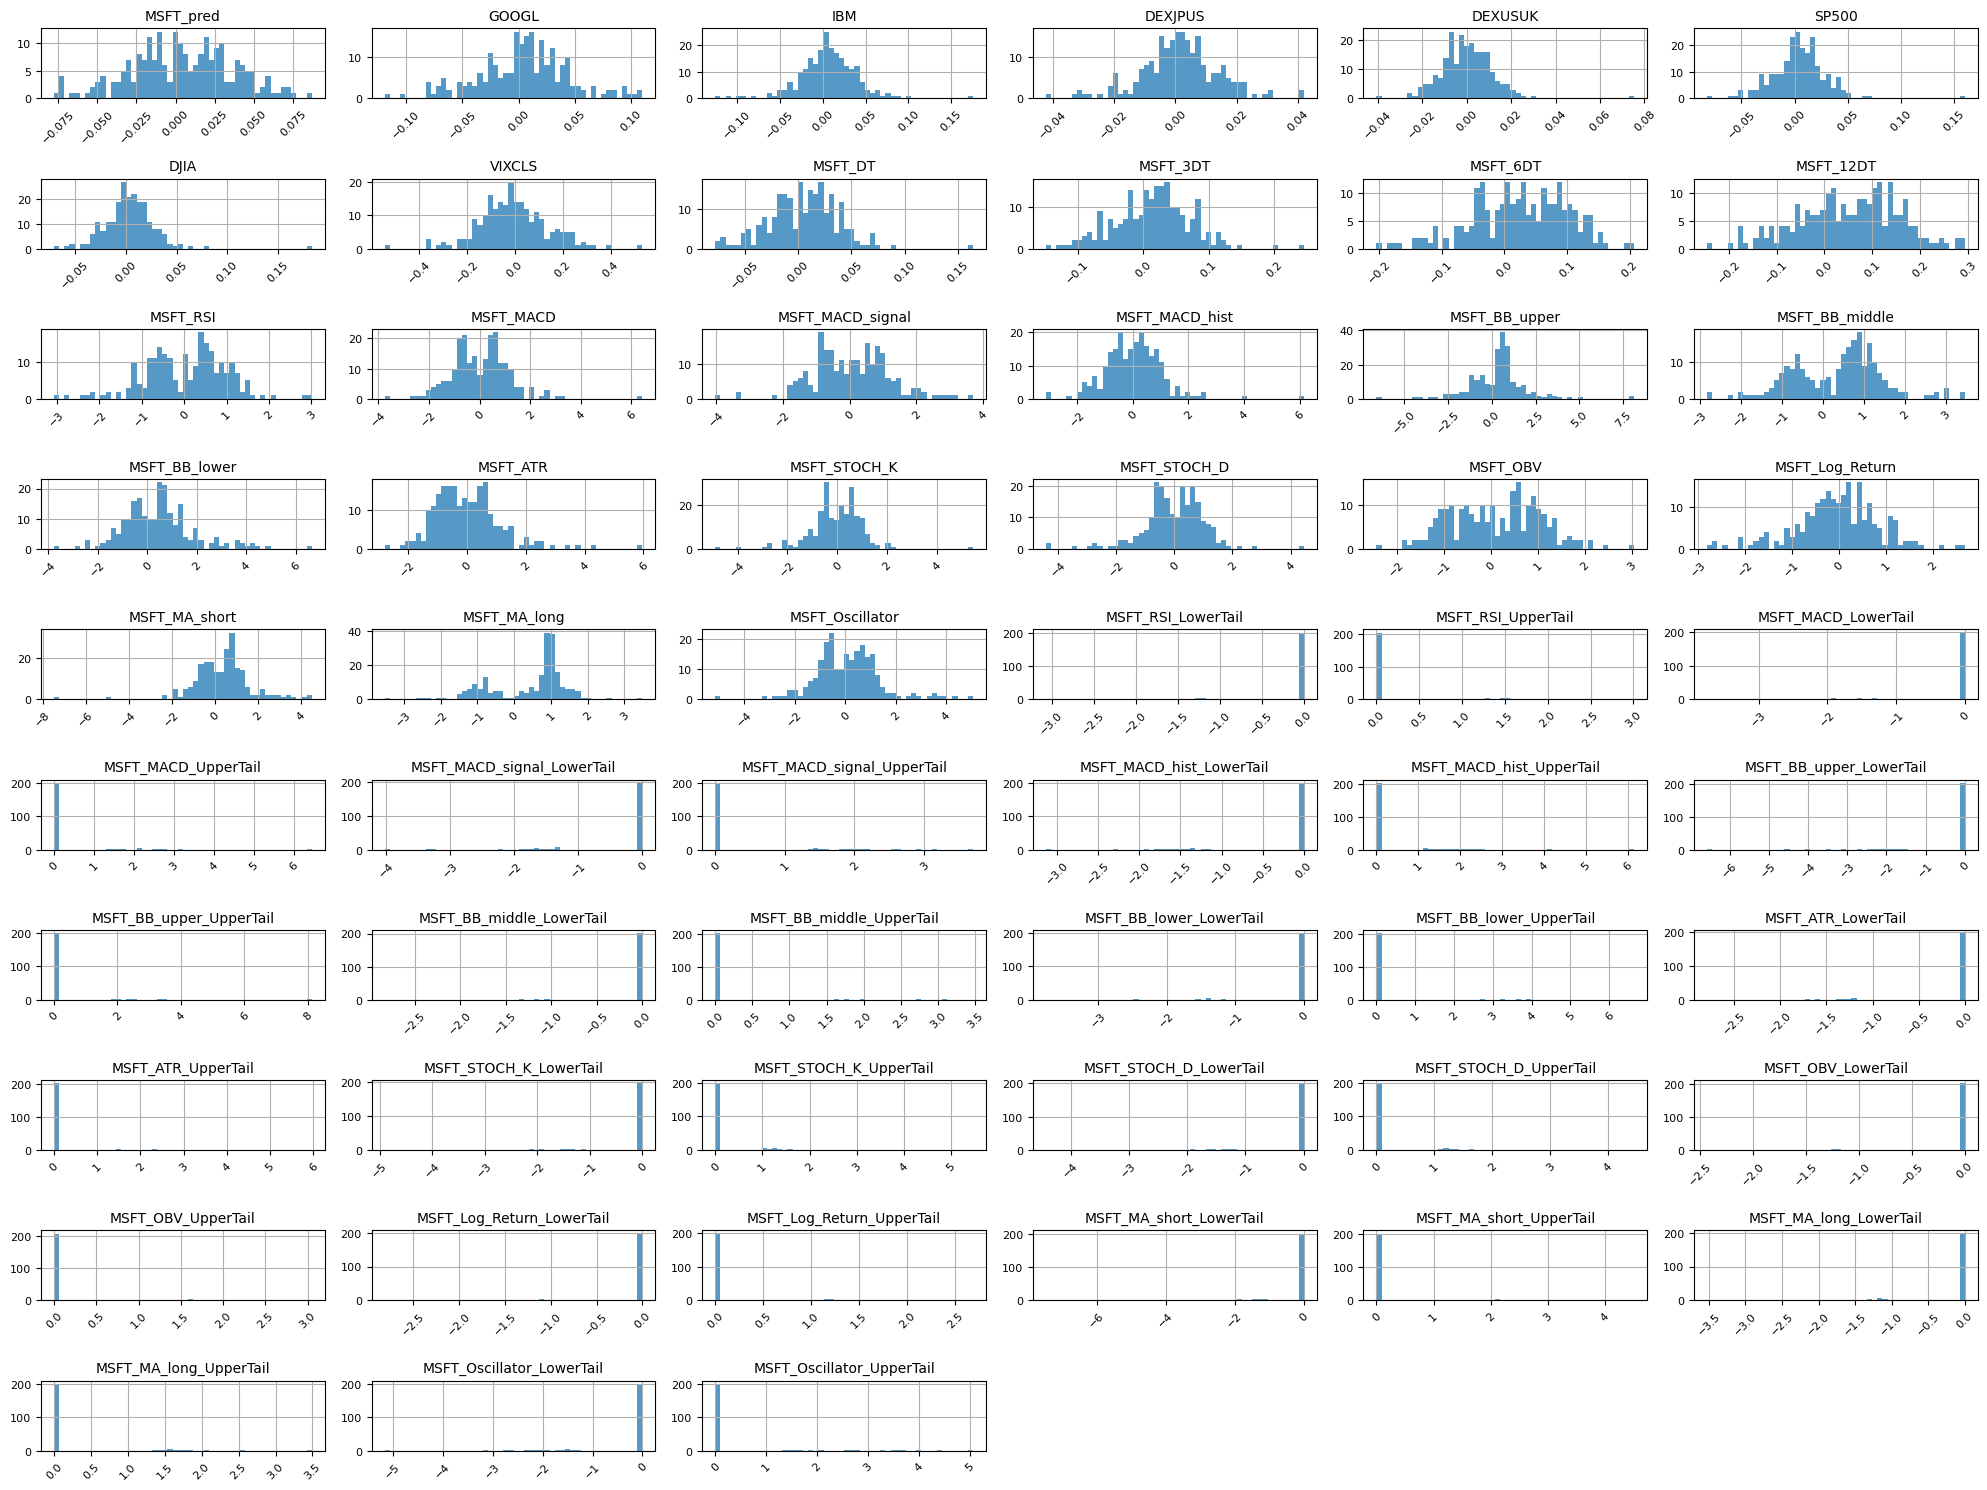

In [20]:
import matplotlib.pyplot as plt

# Number of columns in the dataset
num_columns = dataset.shape[1]

# Calculate grid size
ncols = 6  # Number of columns in the grid
nrows = (num_columns + ncols - 1) // ncols  # Calculate the required number of rows

# Create the figure and axes
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))  # Adjust figure size
axes = axes.flatten()  # Flatten axes for easy iteration

# Plot each column as a histogram
for i, column in enumerate(dataset.columns):
    ax = axes[i]
    dataset[column].hist(bins=50, ax=ax, alpha=0.75)
    ax.set_title(column, fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Hide extra axes (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlaps
plt.tight_layout()
plt.show()


The above histogram shows the distribution for each series individually. Next, lets look at the density distribution over the same x axis scale.

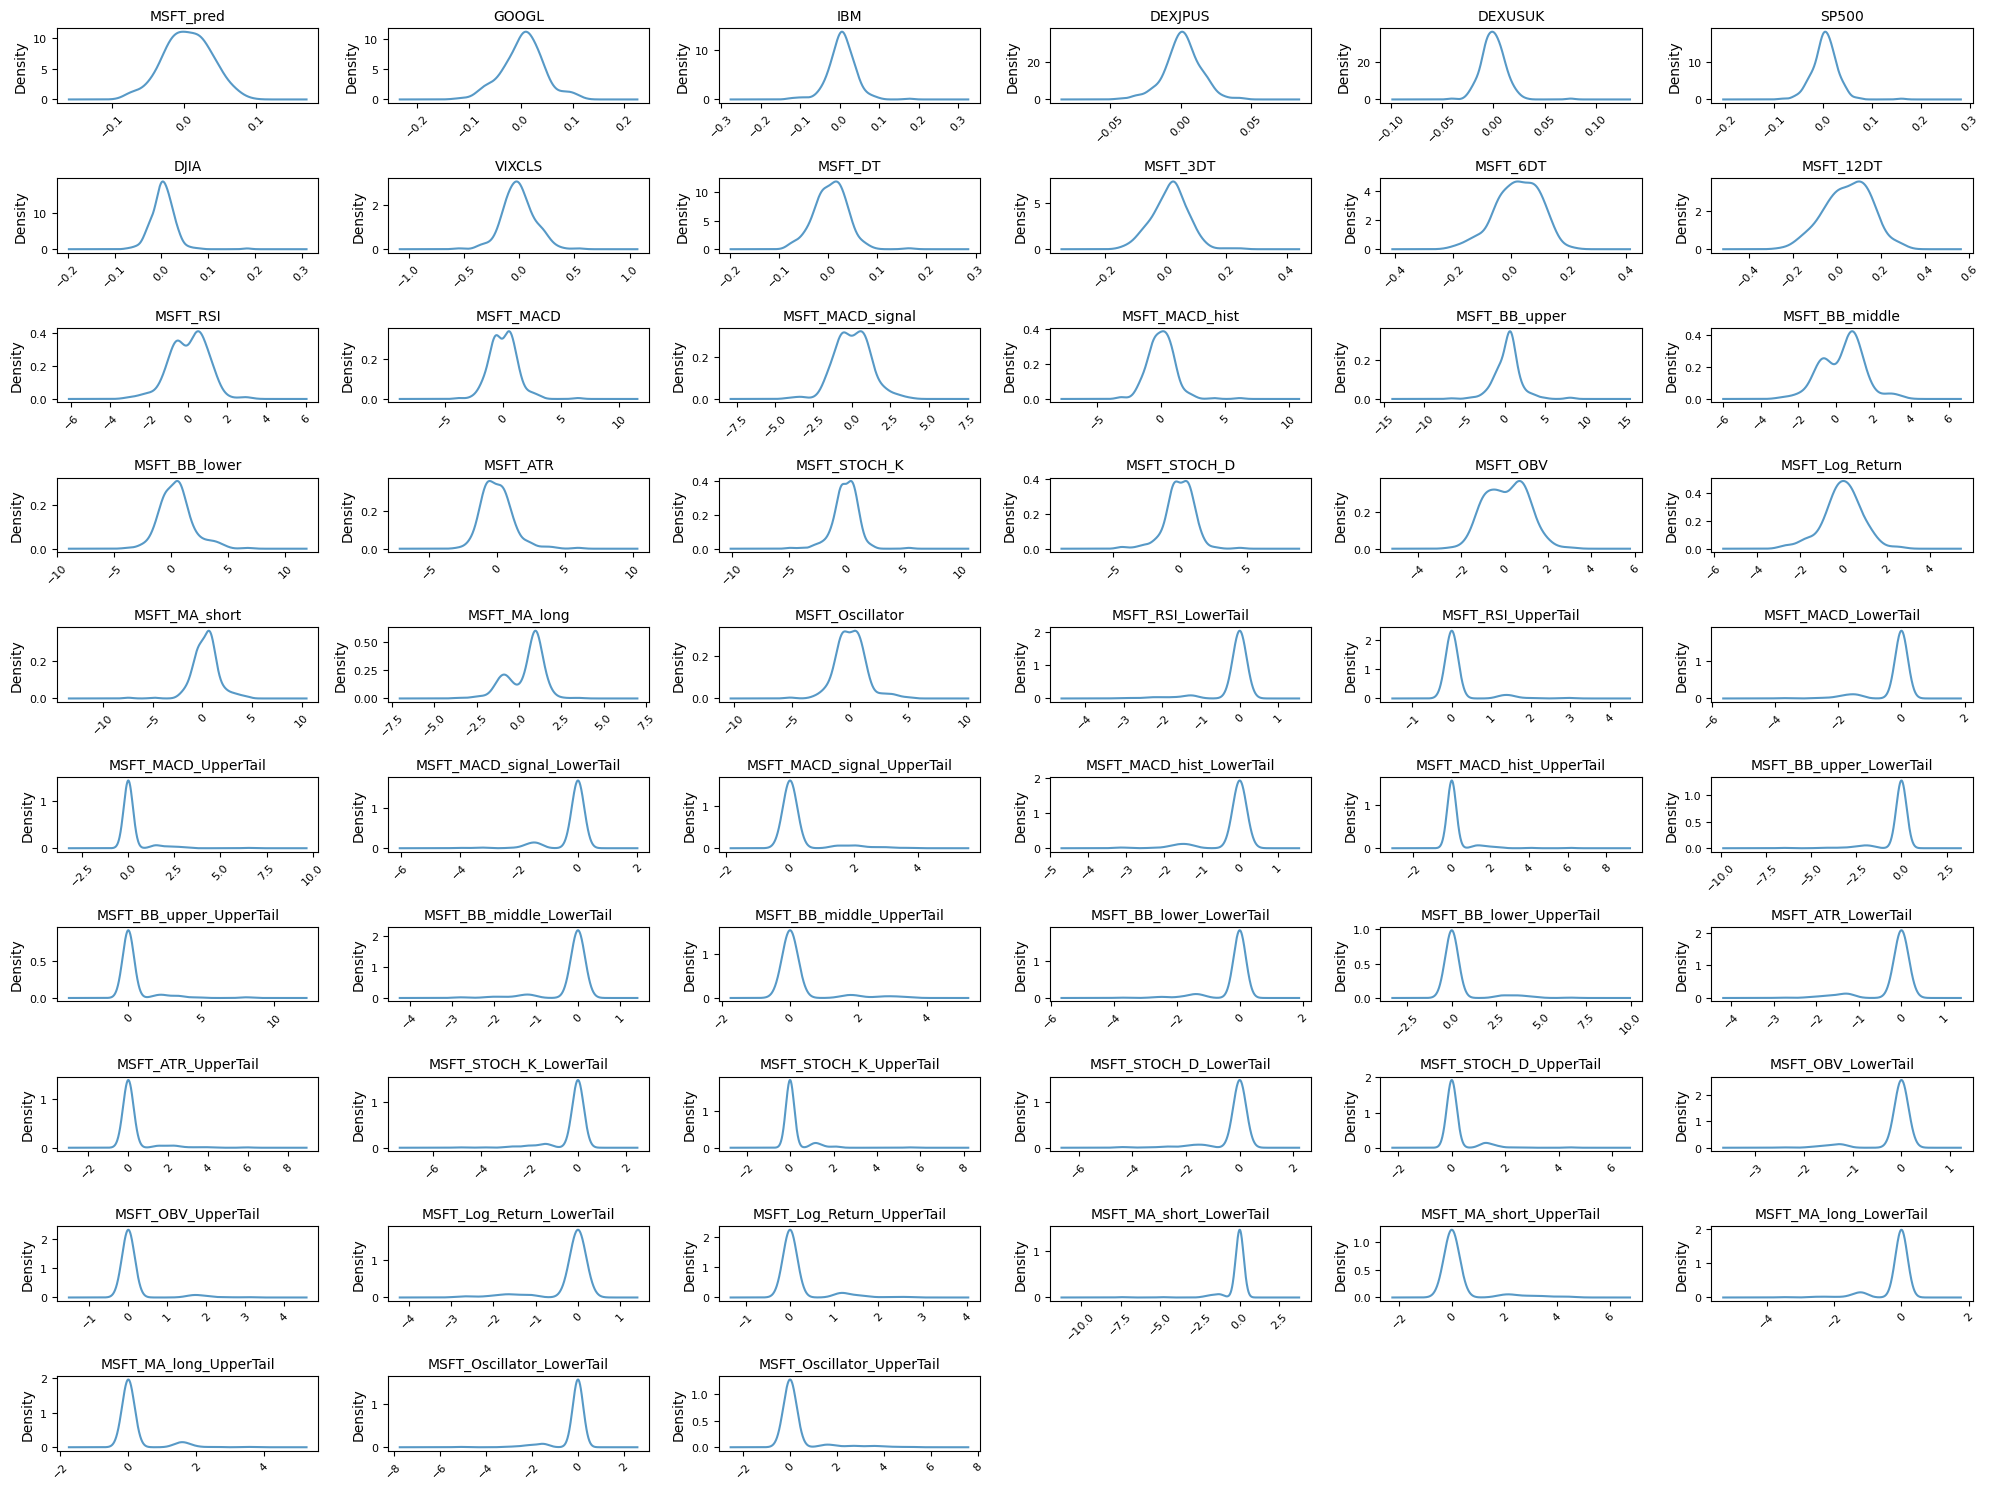

In [21]:
import matplotlib.pyplot as plt

# Number of columns in the dataset
num_columns = dataset.shape[1]

# Calculate grid size
ncols = 6  # Number of columns per row
nrows = (num_columns + ncols - 1) // ncols  # Calculate the number of rows

# Create the figure and axes
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))  # Adjust figure size for density plots
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot density for each column
for i, column in enumerate(dataset.columns):
    ax = axes[i]
    dataset[column].plot(kind='density', ax=ax, alpha=0.75)
    ax.set_title(column, fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


* We can tell that due to IQR Stabilization, the features are more stabilized (By centering them around their rolling mean and scaling them by the  IQR). This transformation reduces the effect of outliers and skes, making the distributions more uniform.   

In order to get a sense of the interdependence of the data we look at the scatter plot and the correlation matrix

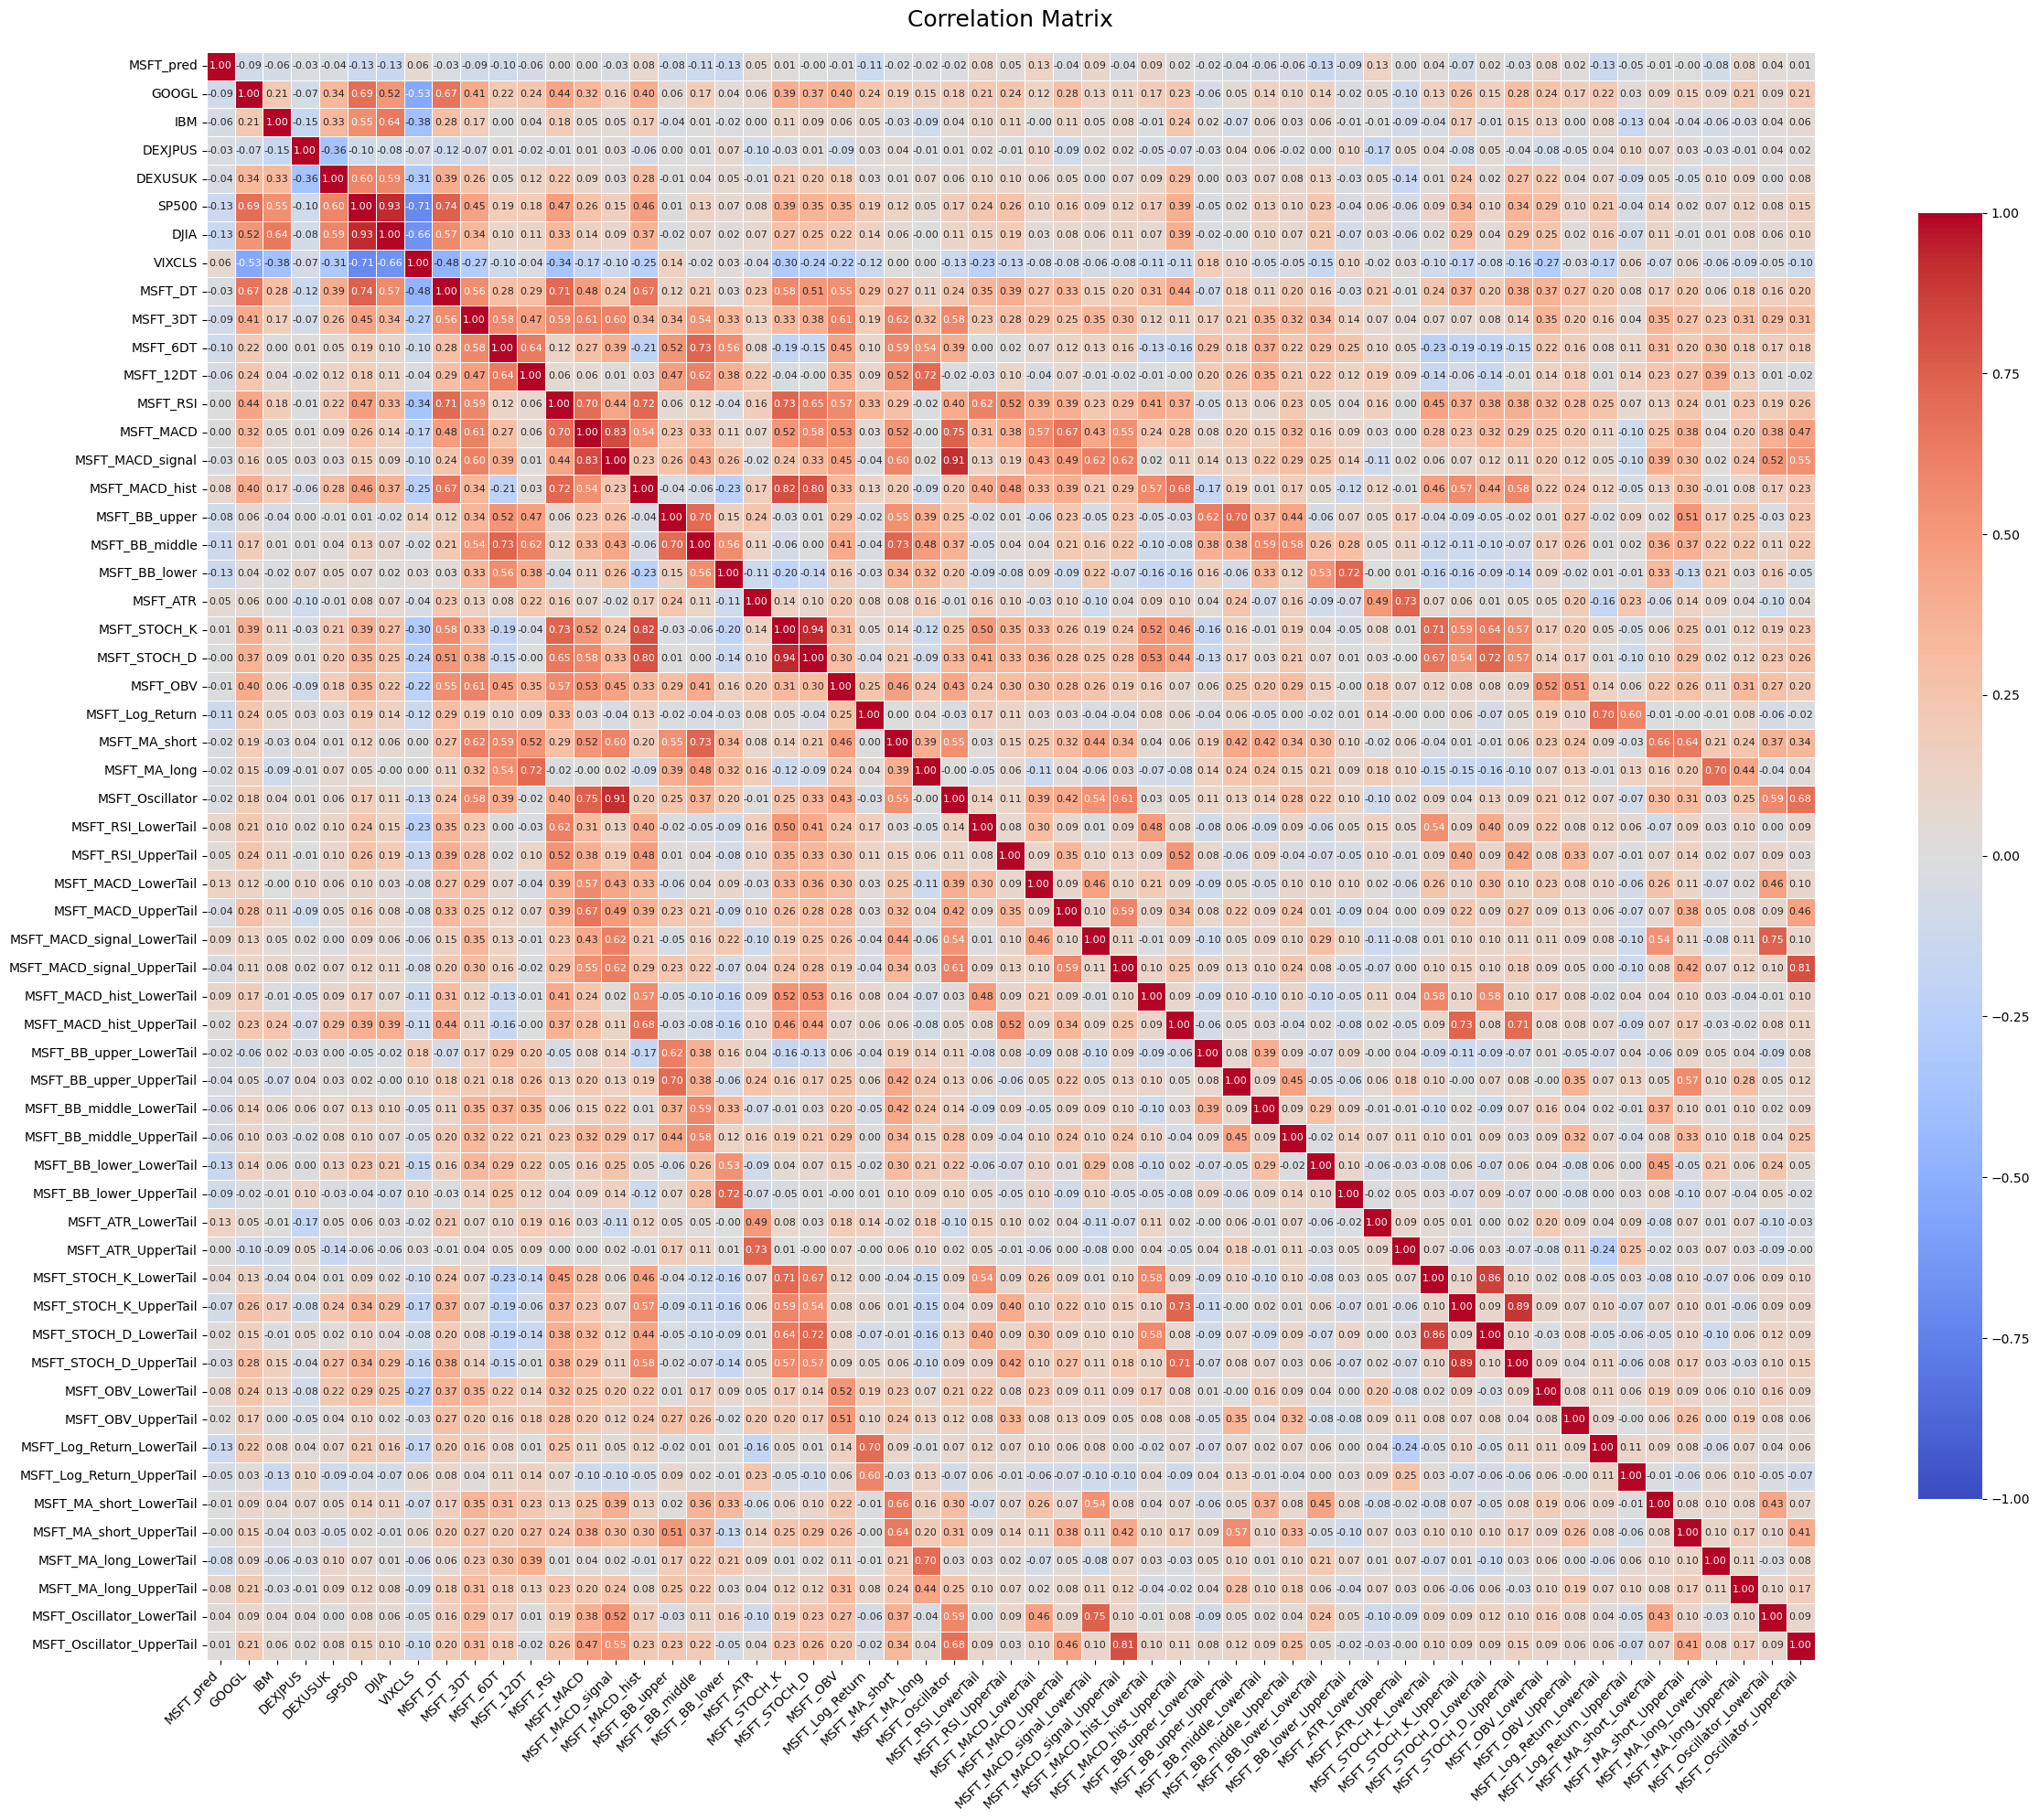

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the correlation matrix
correlation = dataset.corr()

# Set up the matplotlib figure
plt.figure(figsize=(25, 20))  # Increase figure size for better readability

# Draw the heatmap with customizations
sns.heatmap(
    correlation,
    annot=True,  # Annotate with correlation coefficients
    fmt=".2f",  # Format annotations to 2 decimal places
    cmap="coolwarm",  # Use a visually clear colormap
    vmax=1, vmin=-1,  # Set color scale limits
    square=True,  # Make each cell square
    linewidths=0.5,  # Add space between cells
    annot_kws={"size": 8},  # Adjust annotation font size
    cbar_kws={"shrink": 0.8},  # Adjust colorbar size
)

# Customize the title and axis labels
plt.title("Correlation Matrix", fontsize=18, pad=20)
plt.xticks(fontsize=10, rotation=45, ha="right")  # Rotate x-axis labels
plt.yticks(fontsize=10, rotation=0)  # Rotate y-axis labels

# Display the heatmap
plt.tight_layout()
plt.show()


Looking at the correlation plot above, we see some correlation of the predicted vari‐
able with the lagged 5 days, 15days, 30 days and 60 days return of MSFT.

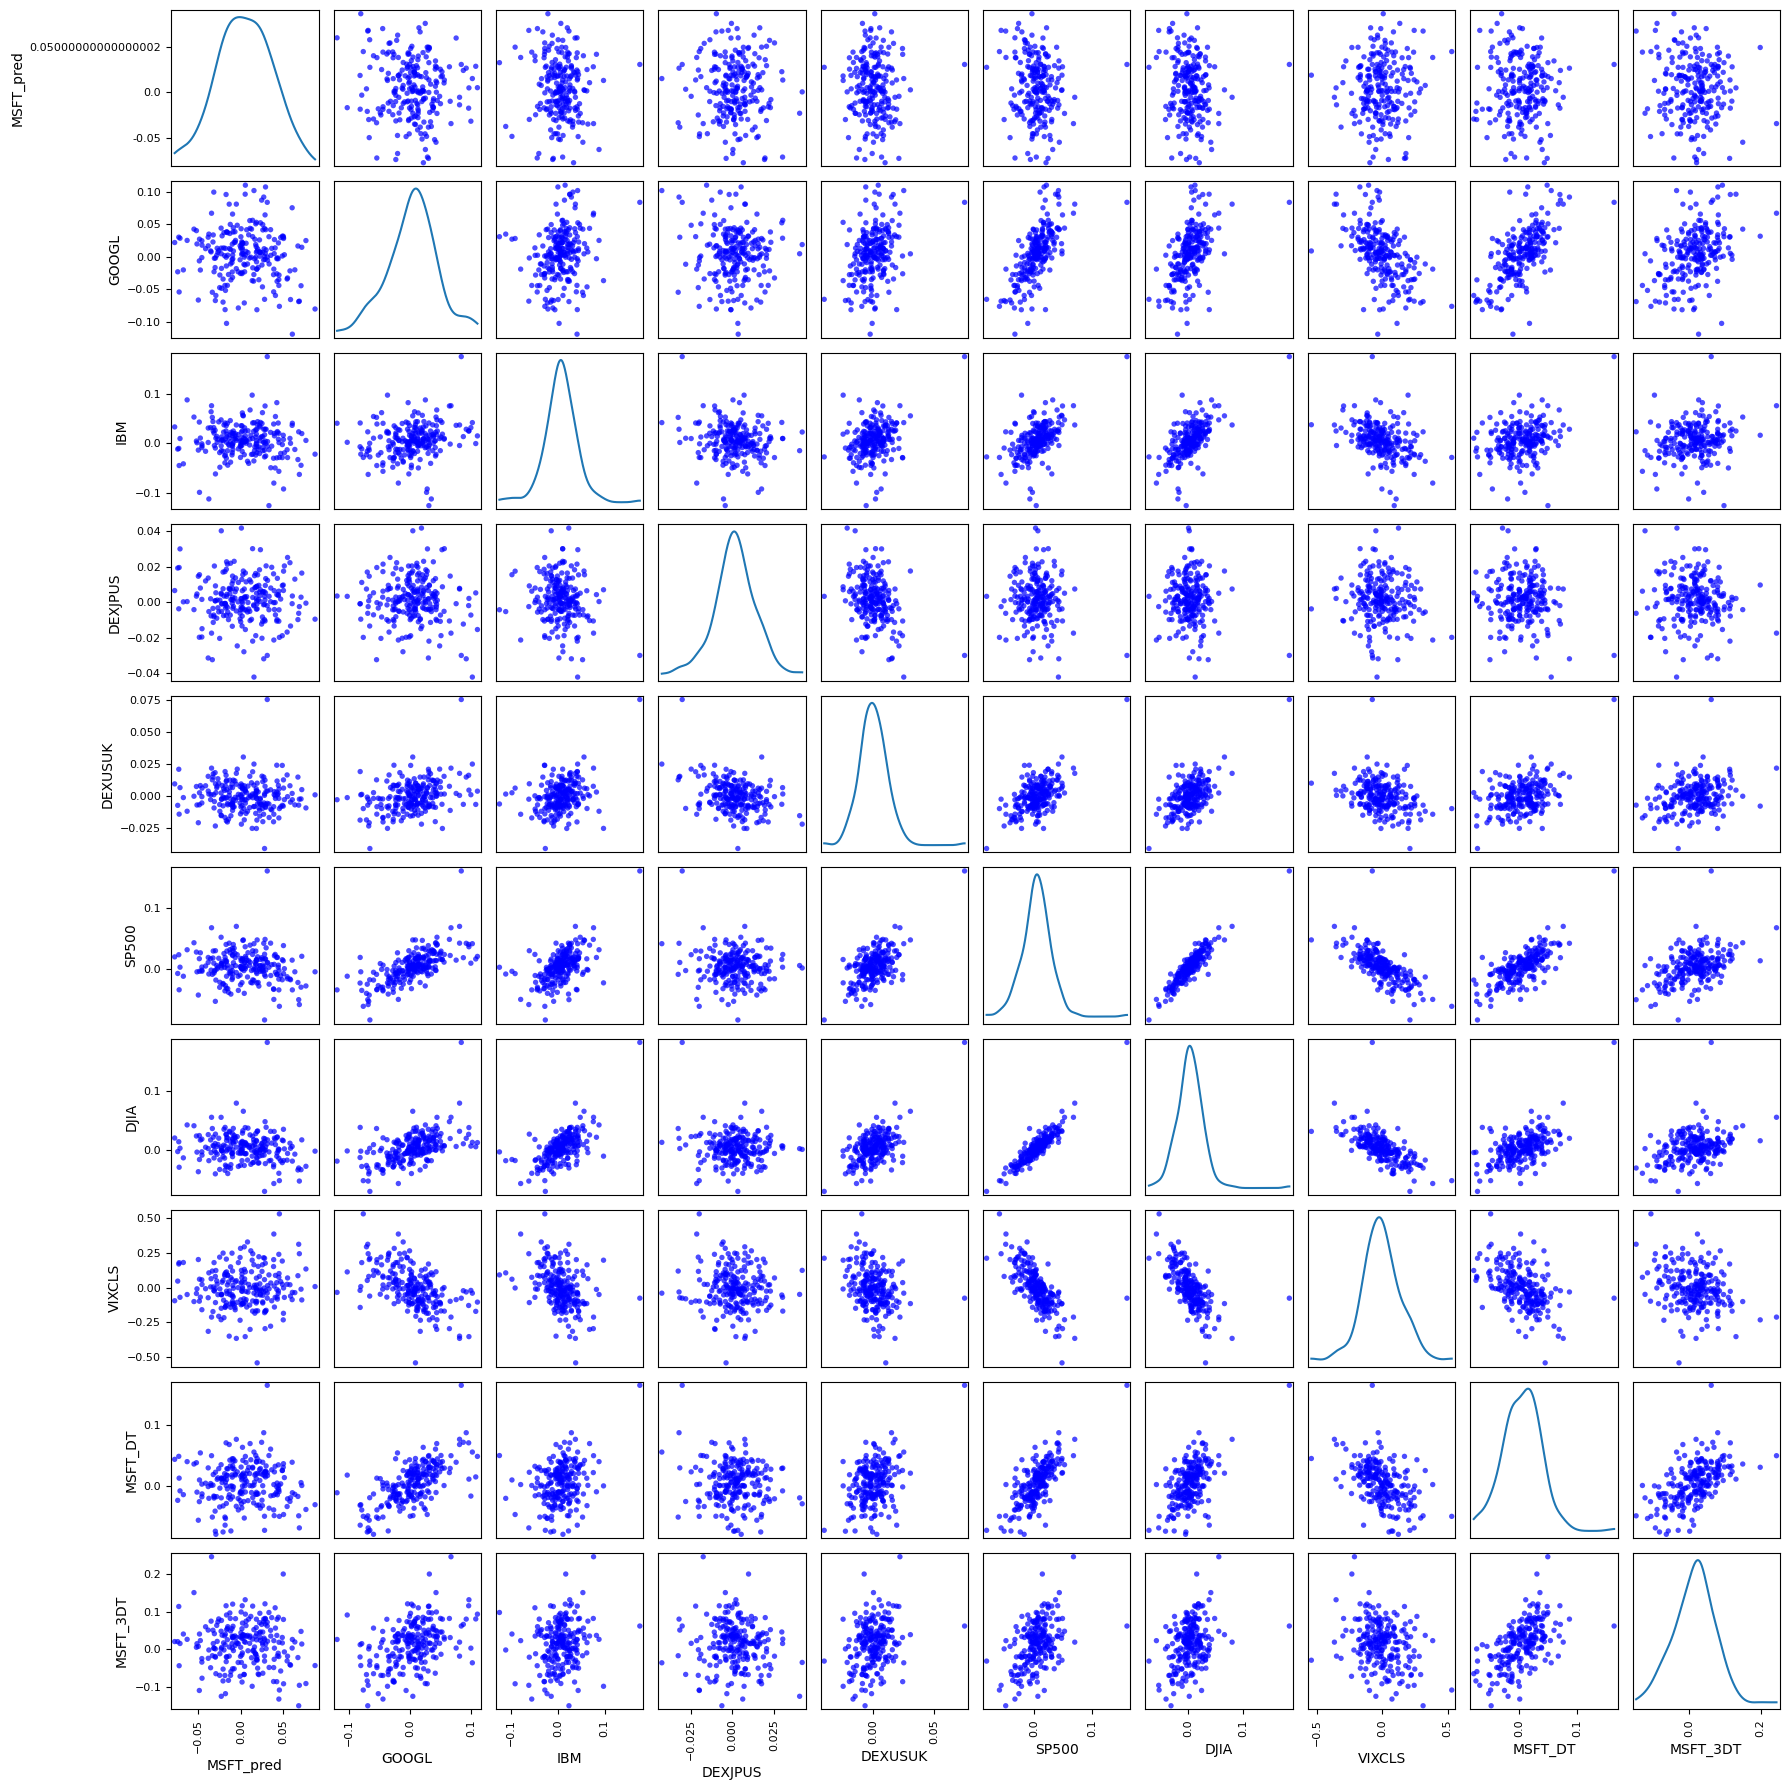

In [23]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# Select a subset of columns (optional)
selected_columns = dataset.columns[:10]  # For example, select the first 10 columns
data_to_plot = dataset[selected_columns]

# Create the scatter matrix
scatter_matrix(
    data_to_plot,
    figsize=(18, 18),  # Increase figure size for better readability
    diagonal='kde',  # Use Kernel Density Estimation (KDE) for histograms on the diagonal
    marker='o',  # Use circles for scatter plots
    s=15,  # Marker size
    alpha=0.7,  # Marker transparency
    color='blue',  # Marker color
    hist_kwds={'bins': 20, 'color': 'lightblue'},  # Customize histogram appearance
    grid=True,  # Add gridlines for better separation
)

# Improve layout
plt.tight_layout()
plt.show()


Looking at the scatter plot above, we see some linear relationship of the predicted
variable the lagged 15 days, 30 days and 60 days return of MSFT.

<a id='2.3'></a>
## 3.3. Time Series Analysis

Next, we look at the seasonal decomposition of our time series

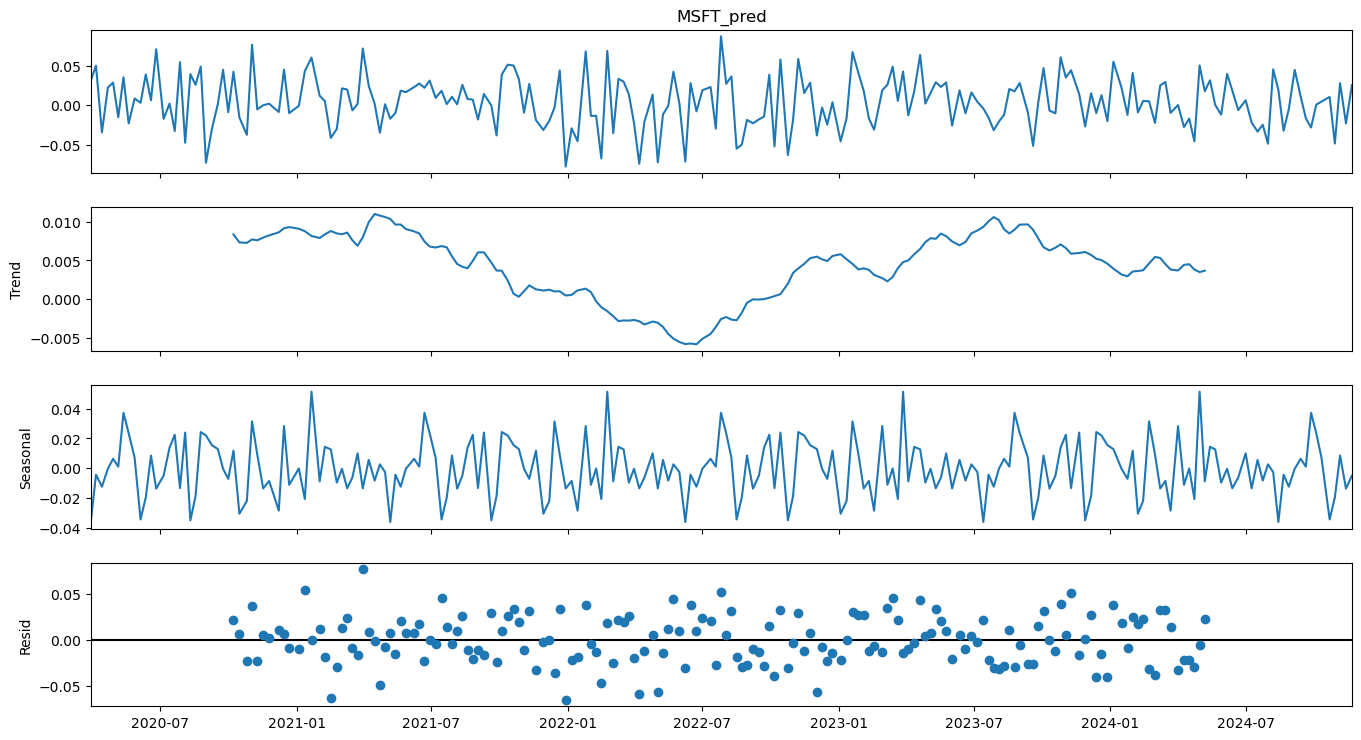

In [24]:
res = sm.tsa.seasonal_decompose(Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

We can see that for MSFT there has been a general trend upwards. This should show up in our the constant/bias terms in our models

<a id='3'></a>
## 4. Data Preparation

<a id='3.2'></a>
## 4.2. Feature Selection - Select Technical Features

We use sklearn's SelectKBest function to get a sense of feature importance.

In [25]:
seed = 7
np.random.seed(7)

##### Method 1: Using Mutual_info_regression to perform feature selection

In [26]:
# Select the technical indicators
from sklearn.feature_selection import SelectPercentile, f_regression, mutual_info_regression

# Test to use which percentile scorer
selector = SelectPercentile(mutual_info_regression, percentile=10)

features_kbest = selector.fit_transform(X[features.columns], Y)

print(f"Original number of features: {features.shape[1]}")
print(f"New number of features: {features_kbest.shape[1]}")

Original number of features: 45
New number of features: 5


In [27]:
arr = np.transpose(selector.get_support())
selected_technical_features = features.columns[arr]
# Select the features that are not selected
unselect_technical_features = features.columns[np.where(selector.get_support() == False)
]
print("Index of best features: ", np.asarray(arr == True).nonzero())
print("Best features: ", selected_technical_features)

# Drop the unselect features using the master dataset (dataset)
dataset_filtered = dataset.drop(columns=unselect_technical_features)
X_mutual_info_regression = dataset_filtered.loc[:, dataset_filtered.columns != Y.name]
Y_mutual_info_regression = dataset_filtered.loc[:, dataset_filtered.columns == Y.name]

Index of best features:  (array([ 0,  3,  5, 15, 23]),)
Best features:  Index(['MSFT_RSI', 'MSFT_MACD_hist', 'MSFT_BB_middle', 'MSFT_RSI_LowerTail',
       'MSFT_BB_upper_LowerTail'],
      dtype='object')


##### Method 2: Use f_regression to perform feature selection

In [28]:
# Select the technical indicators
from sklearn.feature_selection import SelectPercentile, f_regression, mutual_info_regression

# Test to use which percentile scorer
selector = SelectPercentile(f_regression, percentile=10)
# selector = SelectPercentile(mutual_info_regression, percentile=10)

features_kbest = selector.fit_transform(X[features.columns], Y)

print(f"Original number of features: {features.shape[1]}")
print(f"New number of features: {features_kbest.shape[1]}")

Original number of features: 45
New number of features: 5


In [29]:
arr = np.transpose(selector.get_support())
selected_technical_features = features.columns[arr]
# Select the features that are not selected
unselect_technical_features = features.columns[np.where(selector.get_support() == False)
]
print("Index of best features: ", np.asarray(arr == True).nonzero())
print("Best features: ", selected_technical_features)

# Drop the unselect features using the master dataset (dataset)
dataset_filtered = dataset.drop(columns=unselect_technical_features)
X_f_regression = dataset_filtered.loc[:, dataset_filtered.columns != Y.name]
Y_f_regression = dataset_filtered.loc[:, dataset_filtered.columns == Y.name]

Index of best features:  (array([ 6, 17, 27, 29, 37]),)
Best features:  Index(['MSFT_BB_lower', 'MSFT_MACD_LowerTail', 'MSFT_BB_lower_LowerTail',
       'MSFT_ATR_LowerTail', 'MSFT_Log_Return_LowerTail'],
      dtype='object')


#### Method 3: Use PCA to find the important features

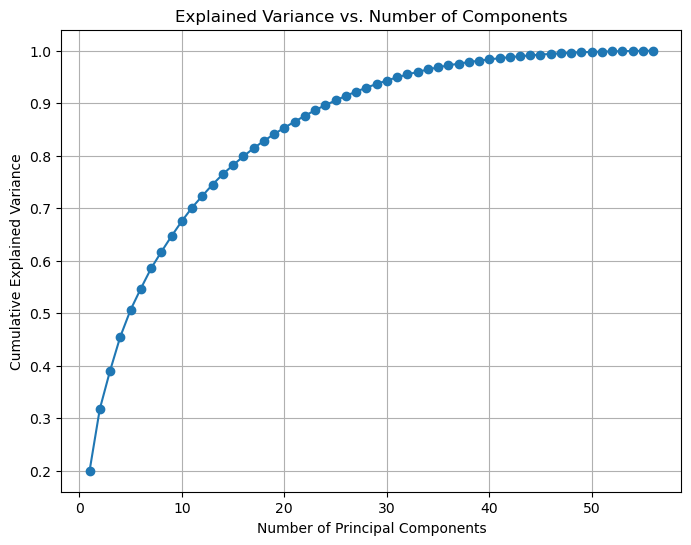

In [30]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Assuming X is your input features dataframe
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA without specifying n_components to get all components
pca_full = PCA()
pca_full.fit(X_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()



 The actual implementation of using PCA is integreated in the pipeline (Shown in next section)

#### Method 4: Use Random Forest to identify the Feature Importance

In [31]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

model = RandomForestRegressor(random_state=seed)
model.fit(X[features.columns], Y)

# Feature importance
feature_importances = pd.DataFrame({'feature': features.columns,
                                    'importance': model.feature_importances_})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
print(feature_importances)


                       feature  importance
12               MSFT_MA_short       0.074
7                     MSFT_ATR       0.070
5               MSFT_BB_middle       0.068
11             MSFT_Log_Return       0.064
6                MSFT_BB_lower       0.062
4                MSFT_BB_upper       0.061
13                MSFT_MA_long       0.058
10                    MSFT_OBV       0.056
1                    MSFT_MACD       0.054
0                     MSFT_RSI       0.053
2             MSFT_MACD_signal       0.051
14             MSFT_Oscillator       0.051
9                 MSFT_STOCH_D       0.045
3               MSFT_MACD_hist       0.043
8                 MSFT_STOCH_K       0.029
29          MSFT_ATR_LowerTail       0.021
24     MSFT_BB_upper_UpperTail       0.014
37   MSFT_Log_Return_LowerTail       0.014
19  MSFT_MACD_signal_LowerTail       0.013
43   MSFT_Oscillator_LowerTail       0.010
22    MSFT_MACD_hist_UpperTail       0.009
25    MSFT_BB_middle_LowerTail       0.006
27     MSFT

In [32]:
# Select the top 5 features accordingly
top_features = feature_importances['feature'].head(5).tolist()
unselect_techincal_features = feature_importances['feature'].iloc[5:].tolist()
print("Top Selected Features:", top_features)
print("Unselected Features:", unselect_techincal_features)

# Drop the unselect features using the master dataset (dataset)
dataset_filtered = dataset.drop(columns=unselect_technical_features)
X_rf_importance = dataset_filtered.loc[:, dataset_filtered.columns != Y.name]
Y_rf_importance = dataset_filtered.loc[:, dataset_filtered.columns == Y.name]

Top Selected Features: ['MSFT_MA_short', 'MSFT_ATR', 'MSFT_BB_middle', 'MSFT_Log_Return', 'MSFT_BB_lower']
Unselected Features: ['MSFT_BB_upper', 'MSFT_MA_long', 'MSFT_OBV', 'MSFT_MACD', 'MSFT_RSI', 'MSFT_MACD_signal', 'MSFT_Oscillator', 'MSFT_STOCH_D', 'MSFT_MACD_hist', 'MSFT_STOCH_K', 'MSFT_ATR_LowerTail', 'MSFT_BB_upper_UpperTail', 'MSFT_Log_Return_LowerTail', 'MSFT_MACD_signal_LowerTail', 'MSFT_Oscillator_LowerTail', 'MSFT_MACD_hist_UpperTail', 'MSFT_BB_middle_LowerTail', 'MSFT_BB_lower_LowerTail', 'MSFT_STOCH_D_UpperTail', 'MSFT_MA_long_LowerTail', 'MSFT_BB_lower_UpperTail', 'MSFT_BB_upper_LowerTail', 'MSFT_BB_middle_UpperTail', 'MSFT_RSI_UpperTail', 'MSFT_RSI_LowerTail', 'MSFT_MACD_hist_LowerTail', 'MSFT_STOCH_D_LowerTail', 'MSFT_MACD_LowerTail', 'MSFT_ATR_UpperTail', 'MSFT_Oscillator_UpperTail', 'MSFT_OBV_LowerTail', 'MSFT_STOCH_K_UpperTail', 'MSFT_MA_short_LowerTail', 'MSFT_MA_long_UpperTail', 'MSFT_STOCH_K_LowerTail', 'MSFT_MACD_signal_UpperTail', 'MSFT_MACD_UpperTail', 'MSFT_

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

Next, we start by splitting our data in training and testing chunks. If we are going to use Time series models we have to split the data in continous series.

In [33]:
# Make this a function for reproducibility
def train_test_split(feature_selector_method, test_size=0.2):

  validation_size = test_size

  feature_selector = ['f_regression', 'mutual_info_regression', 'pca', 'random_forest_importance']

  feature_selector_method = feature_selector_method.lower()

  x_y_data = [(X_f_regression, Y_f_regression), (X_mutual_info_regression, Y_mutual_info_regression), (X, Y), (X_rf_importance, Y_rf_importance)]

  X_filtered, Y_filtered = x_y_data[feature_selector.index(feature_selector_method)]


  train_size = int(len(X_filtered) * (1-validation_size))
  X_train, X_test = X_filtered[0:train_size], X_filtered[train_size:len(X)]
  Y_train, Y_test = Y_filtered[0:train_size], Y_filtered[train_size:len(X)]

  return X_train, X_test, Y_train, Y_test

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics

In [34]:
num_folds = 10
# scikit is moving away from mean_squared_error.
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

<a id='4.3.1'></a>
### 5.3.1 Machine Learning models-from scikit-learn

##### Standardized with respective models

##### Unstandardized models

In [35]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor()))
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Once we have selected all the models, we loop over each of them. First we run the K-fold analysis. Next we run the model on the entire training and testing dataset.

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

feature_selector = ['f_regression', 'mutual_info_regression', 'pca', 'random_forest_importance']

lowest_test_results = {}
kfold_results = {}
train_results = {}
test_results = {}

for feature_selector_method in feature_selector:
  print("\n" + feature_selector_method)
  X_train, X_test, Y_train, Y_test = train_test_split(feature_selector_method)

  names = []
  feature_selector_kfold_results = {}
  feature_selector_test_results = {}
  feature_selector_train_results = {}

  for name, model in models:

      names.append(name)

      if feature_selector_method == 'pca':
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.85, random_state=seed)),
        ('model', model)
        ])
        model = pipeline

      # kfold = KFold(n_splits=num_folds, random_state=seed)
      kfold = KFold(n_splits=num_folds, shuffle=False)
      #converted mean square error to positive. The lower the beter
      cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
      feature_selector_kfold_results[name] = (cv_results)


      # Full Training period
      res = model.fit(X_train, Y_train)
      train_result = mean_squared_error(res.predict(X_train), Y_train)

      feature_selector_train_results[name] = train_result

      # Test results
      test_result = mean_squared_error(res.predict(X_test), Y_test)
      feature_selector_test_results[name] = test_result

      msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
      print(msg)

  # After finish all the models store the result
  kfold_results[feature_selector_method] = feature_selector_kfold_results
  train_results[feature_selector_method] = feature_selector_train_results
  test_results[feature_selector_method] = feature_selector_test_results

  print(f"Lowest Test Results: {names[np.argmin(np.array(list(feature_selector_test_results.values())))]}, {np.min(np.array(list(feature_selector_test_results.values())))}")
  lowest_test_results[feature_selector_method] = (names[np.argmin(np.array(list(feature_selector_test_results.values())))], np.min(np.array(list(feature_selector_test_results.values()))))

# Find the lowest test results
selector = list(lowest_test_results.keys())[np.argmin(np.array([i[1] for i in lowest_test_results.values()]))]
print(f"\nLowest Test Results Among the all: Selector ({selector}, {lowest_test_results[selector]})")


f_regression
LR: 0.001277 (0.000473) 0.001041 0.000638
LASSO: 0.001126 (0.000497) 0.001126 0.000738
EN: 0.001126 (0.000497) 0.001126 0.000738


  File "c:\Users\User\anaconda3\envs\APS1052_Final\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


KNN: 0.001408 (0.000617) 0.000935 0.000880
CART: 0.002312 (0.001042) 0.000000 0.002246
SVR: 0.001121 (0.000491) 0.001127 0.000736
MLP: 0.003717 (0.002258) 0.002981 0.002953
ABR: 0.001423 (0.000668) 0.000619 0.000800
GBR: 0.001481 (0.000694) 0.000110 0.001068
RFR: 0.001286 (0.000582) 0.000172 0.000808
ETR: 0.001314 (0.000604) 0.000000 0.000804
Lowest Test Results: LR, 0.0006375954672395948

mutual_info_regression
LR: 0.001250 (0.000454) 0.001053 0.000693
LASSO: 0.001126 (0.000497) 0.001126 0.000738
EN: 0.001126 (0.000497) 0.001126 0.000738
KNN: 0.001408 (0.000541) 0.000985 0.000695
CART: 0.002929 (0.001174) 0.000000 0.001458
SVR: 0.001121 (0.000491) 0.001127 0.000736
MLP: 0.003702 (0.001662) 0.005102 0.004567
ABR: 0.001328 (0.000577) 0.000542 0.000851
GBR: 0.001631 (0.000736) 0.000097 0.001047
RFR: 0.001268 (0.000599) 0.000171 0.000786
ETR: 0.001273 (0.000615) 0.000000 0.000781
Lowest Test Results: LR, 0.0006932577220973687

pca
LR: 0.001249 (0.000499) 0.001007 0.000675
LASSO: 0.001126 

#### K Fold results

We being by looking at the K Fold results

The best model can be concluded as using feature selection **pca** and model **"ETR"**

In [37]:
kfold_results['pca']

{'LR': array([0.00139179, 0.00182178, 0.00102423, 0.0003661 , 0.00176296,
        0.00162772, 0.00191599, 0.00090117, 0.00084952, 0.00083052]),
 'LASSO': array([0.00110467, 0.00130331, 0.00087385, 0.00029839, 0.00175043,
        0.00165173, 0.00189038, 0.00102326, 0.00055873, 0.0008067 ]),
 'EN': array([0.00110467, 0.00130331, 0.00087385, 0.00029839, 0.00175043,
        0.00165173, 0.00189038, 0.00102326, 0.00055873, 0.0008067 ]),
 'KNN': array([0.0013605 , 0.00164199, 0.00115711, 0.00048826, 0.001725  ,
        0.00156584, 0.00264447, 0.00104189, 0.00070759, 0.00082464]),
 'CART': array([0.00182549, 0.00233115, 0.00186454, 0.00182549, 0.00209959,
        0.00348386, 0.00209859, 0.00235471, 0.00146814, 0.00169107]),
 'SVR': array([0.00110269, 0.00130379, 0.00087454, 0.00029674, 0.00176081,
        0.00162669, 0.00185896, 0.00102394, 0.00055919, 0.00080596]),
 'MLP': array([0.1464341 , 0.03754241, 0.05532895, 0.01992631, 0.06912365,
        0.08262696, 0.02876616, 0.07857394, 0.01498052

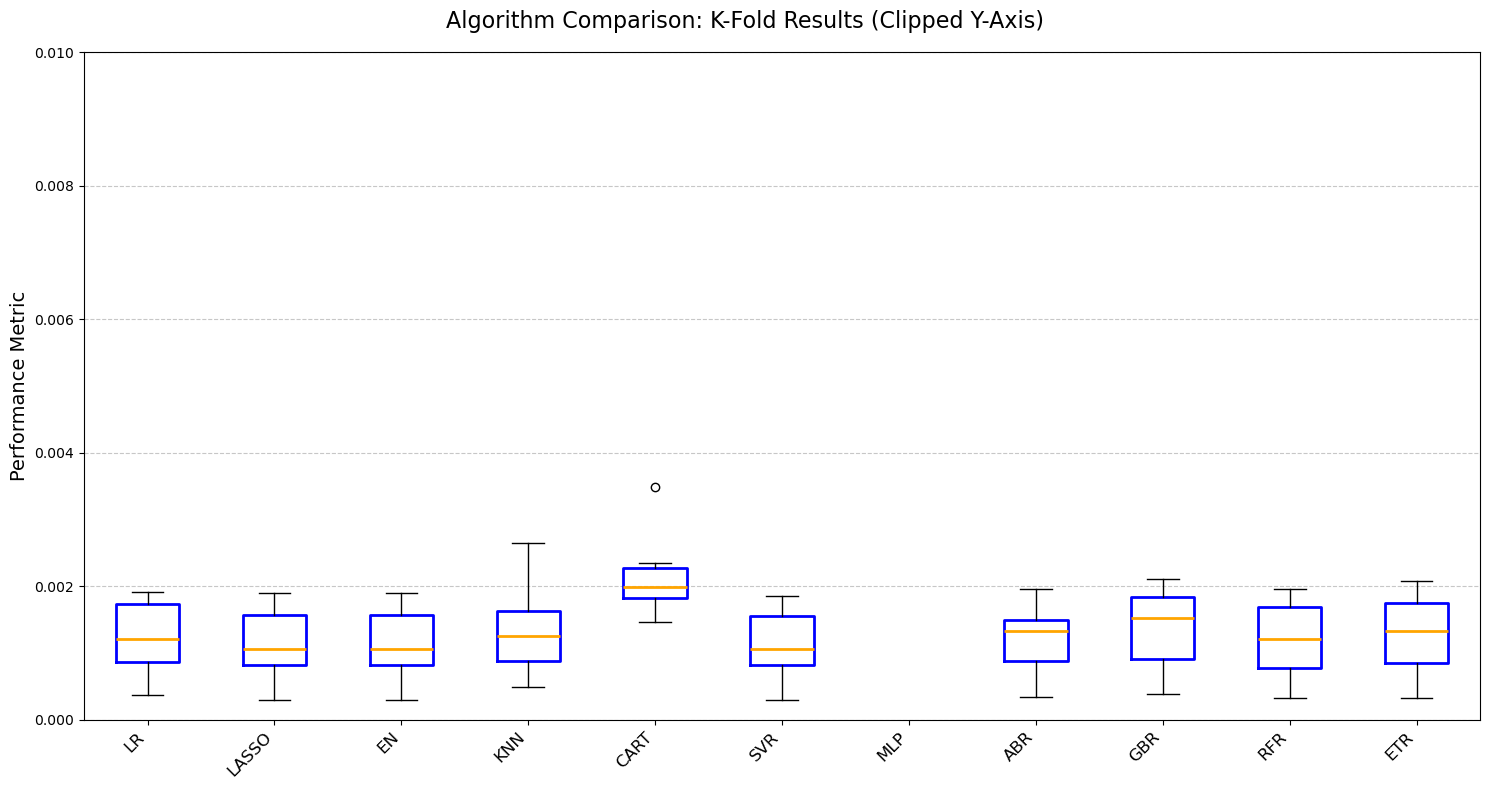

In [38]:
# Clip the y-axis
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Algorithm Comparison: K-Fold Results (Clipped Y-Axis)', fontsize=16)
ax = fig.add_subplot(111)
ax.boxplot(kfold_results['pca'].values(), boxprops=dict(color='blue', linewidth=2), medianprops=dict(color='orange', linewidth=2))

# Set y-axis limits
ax.set_ylim([0, 0.01])  # Adjust the range to focus on smaller values
ax.set_xticklabels(names, fontsize=12, rotation=45, ha='right')
ax.set_ylabel('Performance Metric', fontsize=14)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


We see the linear regression and the regularized regression including the Lasso regression (LASSO) and elastic net (EN) seem to do a good job.

#### Training and Test error

We can tell that using PCA as feature selector and using Machine Learning model "ETR" gives the best result. Therefore, we will plot the training and testing error accordingly

In [39]:
train_results['pca']

{'LR': np.float64(0.0010071536171847664),
 'LASSO': np.float64(0.0011264954292588409),
 'EN': np.float64(0.0011264954292588409),
 'KNN': np.float64(0.0009038308957681246),
 'CART': np.float64(0.0),
 'SVR': np.float64(0.001126629144928541),
 'MLP': np.float64(0.0059877293989373664),
 'ABR': np.float64(0.0004795165959228592),
 'GBR': np.float64(6.636860139186171e-05),
 'RFR': np.float64(0.000167662530384837),
 'ETR': np.float64(0.0)}

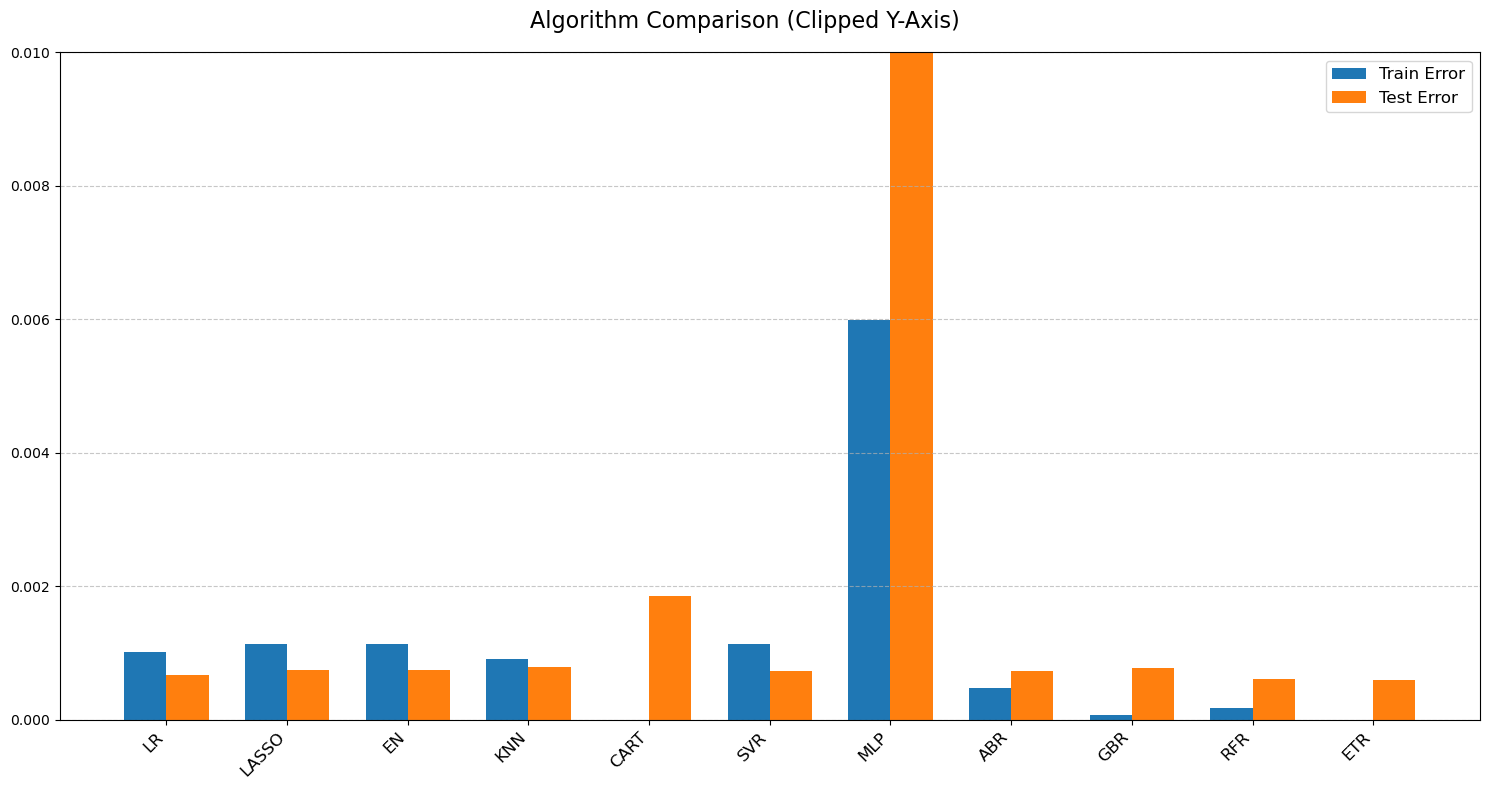

In [40]:
# Set up x locations and bar width
ind = np.arange(len(names))  # x locations
width = 0.35  # width of bars

# Create the plot
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Algorithm Comparison (Clipped Y-Axis)', fontsize=16)

ax = fig.add_subplot(111)

# Bar plots for train and test errors
ax.bar(ind - width / 2, train_results['pca'].values(), width=width, label='Train Error')
ax.bar(ind + width / 2, test_results['pca'].values(), width=width, label='Test Error')

# Set x-axis labels and legend
ax.set_xticks(ind)
ax.set_xticklabels(names, fontsize=12, rotation=45, ha='right')
ax.legend(fontsize=12)

# Clip the y-axis
ax.set_ylim([0, 0.01])  # Focus on smaller values, clipping MLP's large error

# Add grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()
plt.show()

Looking at the training and test error, we still see a better performance of the linear models. Some of the algorithms, such as the decision tree regressor (CART) overfit on
the training data and produced very high error on the test set and these models
should be avoided. Ensemble models, such as gradient boosting regression (GBR) and
random forest regression (RFR) have low bias but high variance. We also see that the
artificial neural network (shown as MLP is the chart) algorithm shows higher errors
both in training set and test set, which is perhaps due to the linear relationship of the
variables not captured accurately by ANN or improper hyperparameters or insuffi‐
cient training of the model.

<a id='4.3.1'></a>
### 5.3.1 Time Series based models-ARIMA and LSTM

Let us first prepare the dataset for ARIMA models,
by having only the correlated varriables as exogenous variables.

### Time Series Model - ARIMA Model

In [41]:
from pmdarima import auto_arima


error_Training_ARIMA = {}
error_Test_ARIMA = {}

feature_selector = ['f_regression', 'mutual_info_regression', 'pca', 'random_forest_importance']

for feature_selector_method in feature_selector:
  print("\n" + feature_selector_method)
  X_train, X_test, Y_train, Y_test = train_test_split(feature_selector_method)

  correlation_matrix = X_train.corrwith(Y_train)

  # Sort features by absolute correlation
  selected_features = correlation_matrix.sort_values(ascending=False)[:6]
  selected_features = selected_features.index.tolist()
  print("Top Selected Features:", selected_features)

  # Find the index with respect to the column
  selected_indices = [list(X_train.columns).index(feature) for feature in selected_features]
  selected_indices

  X_train_ARIMA=X_train.iloc[:, selected_indices]
  X_test_ARIMA=X_test.iloc[:, selected_indices]
  tr_len = len(X_train_ARIMA)
  te_len = len(X_test_ARIMA)
  to_len = len(X)

  # modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
  # Use auto_arima to find the best parameters
  model_fit = auto_arima(Y_train, exogenous=X_train_ARIMA, start_p=1, start_q=1,
                    max_p=5, max_q=5, seasonal=False, stepwise=True, trace=True,
                    error_action='ignore', suppress_warnings=True, random_state=42)

  # model_fit = modelARIMA.fit()
  # print(model_fit.summary())

  train_predictions = model_fit.predict_in_sample(start=0, end=len(Y_train) - 1)
  error_Training_ARIMA[feature_selector_method] = mean_squared_error(Y_train, train_predictions)
  predicted = model_fit.predict(X_test_ARIMA.shape[0])
  error_Test_ARIMA[feature_selector_method] = mean_squared_error(Y_test,predicted)
  print(f"ARIMA Test Error: {error_Test_ARIMA[feature_selector_method]}")


f_regression
Top Selected Features: ['DEXJPUS', 'DEXUSUK', 'DJIA', 'GOOGL', 'IBM', 'MSFT_12DT']
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-690.923, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-693.327, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-691.411, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-691.403, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-695.286, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-693.635, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-693.619, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-691.626, Time=0.23 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.965 seconds
ARIMA Test Error: 0.0007381608990367813

mutual_info_regression
Top Selected Features: ['DEXJPUS', 'DEXUSUK', 'DJIA', 'GOOGL', 'IBM', 'MSFT_12DT']
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-690.923, Time=0.18 sec

###  LSTM Model

In [42]:
seq_len = 2 #Length of the seq for the LSTM
X_train, X_test, Y_train, Y_test = train_test_split("pca")


Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]


In [43]:
# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=float(0.0)):
    # Define the Training, Testing Data

    # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed
    model.add(Dense(1))
    optimizer = SGD(learning_rate=learn_rate, momentum=float(momentum))
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

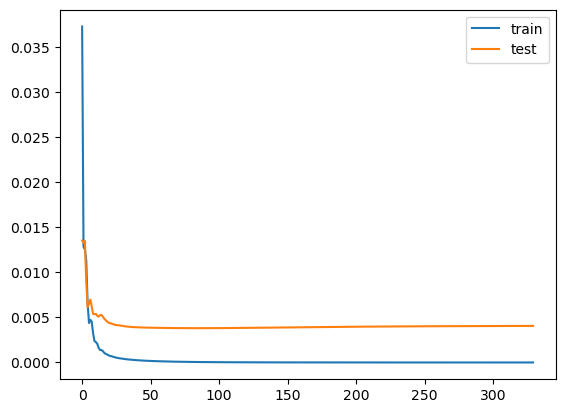

In [44]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [45]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


#### Append to previous results

In [46]:
# Append to pca result
test_results['pca']['ARIMA'] = error_Test_ARIMA['pca']
test_results['pca']['LSTM'] = error_Test_LSTM

train_results['pca']['ARIMA'] = error_Training_ARIMA['pca']
train_results['pca']['LSTM'] = error_Training_LSTM

In [47]:
names.append('ARIMA')
names.append('LSTM')

## Overall Comparison of all the algorithms ( including Time Series Algorithms)

In [48]:
test_results['pca']

{'LR': np.float64(0.0006746934818927931),
 'LASSO': np.float64(0.0007381608990686231),
 'EN': np.float64(0.0007381608990686231),
 'KNN': np.float64(0.00078269273137616),
 'CART': np.float64(0.0018506634648659422),
 'SVR': np.float64(0.0007358679699503646),
 'MLP': np.float64(0.03507439532892441),
 'ABR': np.float64(0.000722817612473998),
 'GBR': np.float64(0.0007700787034587362),
 'RFR': np.float64(0.0006127387337150546),
 'ETR': np.float64(0.000596671124649154),
 'ARIMA': np.float64(0.0007381608990367813),
 'LSTM': np.float64(0.004059930401987641)}

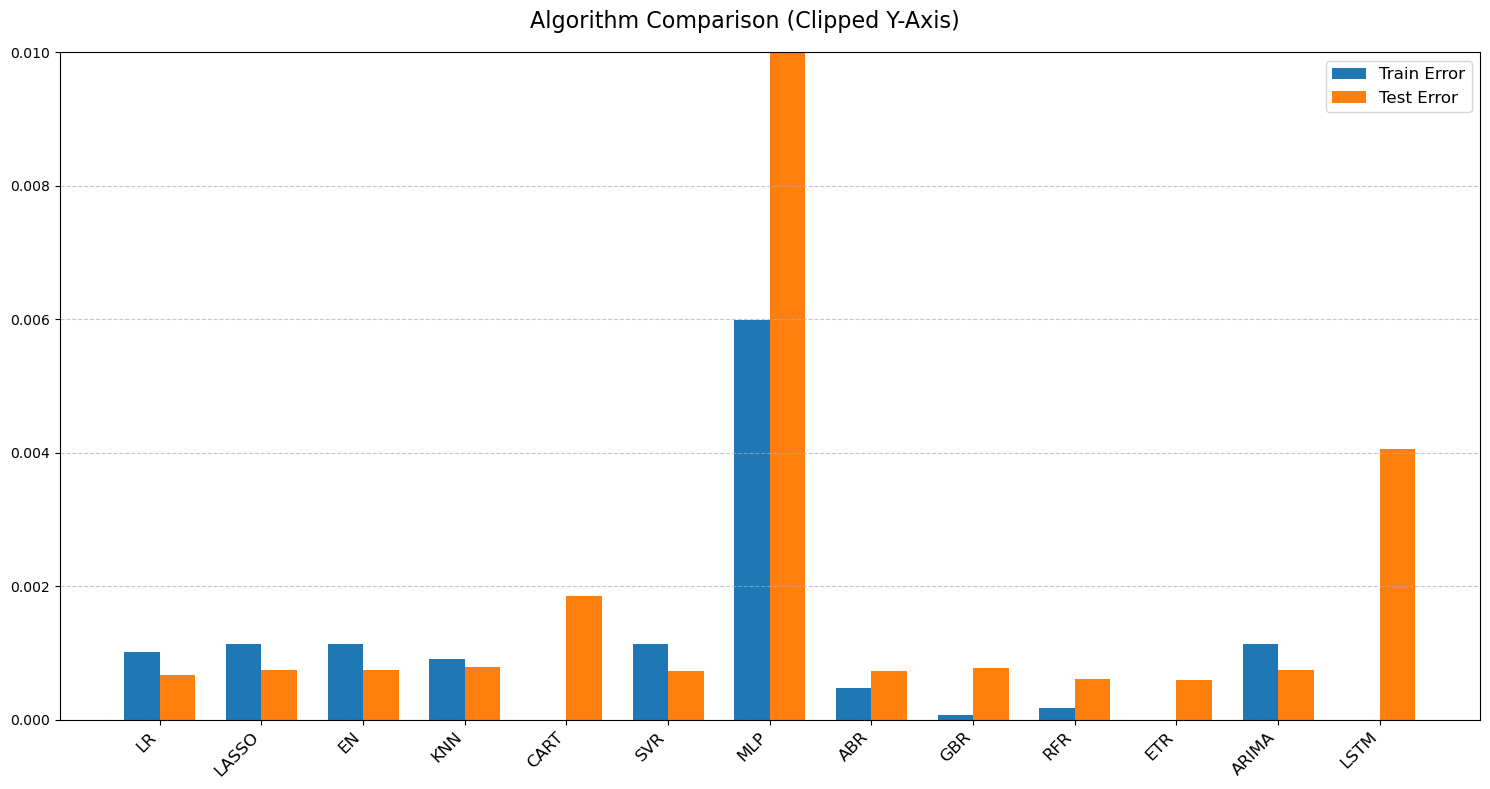

In [49]:
# Set up x locations and bar width
ind = np.arange(len(names))  # x locations
width = 0.35  # width of bars

# Create the plot
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Algorithm Comparison (Clipped Y-Axis)', fontsize=16)

ax = fig.add_subplot(111)

# Bar plots for train and test errors
ax.bar(ind - width / 2, train_results['pca'].values(), width=width, label='Train Error')
ax.bar(ind + width / 2, test_results['pca'].values(), width=width, label='Test Error')

# Set x-axis labels and legend
ax.set_xticks(ind)
ax.set_xticklabels(names, fontsize=12, rotation=45, ha='right')
ax.legend(fontsize=12)

# Clip the y-axis
ax.set_ylim([0, 0.01])  # Focus on smaller values, clipping MLP's large error

# Add grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()
plt.show()

In [50]:
min = float('inf')

for (selector, model_test_error) in test_results.items():
  for (model_name, test_error) in model_test_error.items():
    if test_error < min:
      min = test_error
      min_selector = selector
      min_model_name = model_name

print(f"Lowest Test Results: {min_selector} - {min_model_name}, {min}")

Lowest Test Results: pca - ETR, 0.000596671124649154


Looking at the chart above, we find time series based ARIMA model comparable to
the linear supervised-regression models such as Linear Regression (LR), Lasso Regres‐
sion (LASSO) and Elastic Net (EN). This can primarily be due to the strong linear
relationship as discussed before. The LSTM model performs decently, however,
ARIMA model outperforms the LSTM model in the test set. Hence, we select the
ARIMA model for the model tuning.

<a id='5'></a>
# 6. Model Tuning and Grid Search

As shown in the chart above the ARIMA model is one of the best mode, so we perform the model tuning of the ARIMA model. The default order of ARIMA model is [1,0,0]. We perform a grid search with different combination p,d and q in the ARIMA model's order.  

In [51]:
# Use grid search to search on ETR using PCA feature selector

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the data
    ('pca', PCA()),                # PCA for dimensionality reduction
    ('etr', ExtraTreesRegressor(random_state=42))  # Extra Trees Regressor
])

# Define the parameter grid
param_grid = {
    'pca__n_components': [0.85, 0.9, 0.95],  # Variance explained thresholds
    'etr__n_estimators': [50, 100, 200],      # Number of trees
    'etr__max_depth': [5, 10, None],          # Maximum depth of trees
    'etr__min_samples_split': [2, 5, 10]      # Minimum samples to split a node
}

# Create GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
    cv=5,                              # 5-fold cross-validation
    n_jobs=-1,                         # Use all CPUs
    verbose=2
)

# Fit the grid search
grid_search.fit(X_train, Y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'etr__max_depth': 5, 'etr__min_samples_split': 5, 'etr__n_estimators': 200, 'pca__n_components': 0.85}


<a id='6'></a>
# 7. Finalise the Model

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [52]:

best_model = grid_search.best_estimator_

# Evaluate on the test set
Y_pred = best_model.predict(X_test)
test_mse = mean_squared_error(Y_test, Y_pred)

# Print results
print("Test MSE:", test_mse)

Test MSE: 0.0006409014140647122


## 7.2. Evaluate with Financial Metrics

In [53]:

# Financial metrics functions
def calculate_profit_factor(returns):
    gross_profit = returns[returns > 0].sum()
    gross_loss = abs(returns[returns < 0].sum())
    return gross_profit / gross_loss if gross_loss > 0 else np.inf

def calculate_cagr(returns):
    cum_log_return = np.cumsum(returns)
    cum_percentage_return = np.exp(cum_log_return)-1

    # Calculate CAGR
    trading_days = len(returns)*5
    years = trading_days/252
    cagr = (cum_percentage_return[-1] + 1) ** (1 / years) - 1

    return cagr

def calculate_sharpe_ratio(returns):
    return (252.0 ** (1.0/2.0)) * returns.mean() / returns.std() if returns.std() > 0 else np.inf

# Evaluate the best model with financial metrics
def evaluate_trading_metrics(predictions, actual_returns):
    returns = actual_returns * predictions
    profit_factor = calculate_profit_factor(returns)
    cagr = calculate_cagr(returns)
    sharpe_ratio = calculate_sharpe_ratio(returns)
    return profit_factor, cagr, sharpe_ratio

# SHAP analysis for feature importance
def analyze_feature_importance(model, X_train):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train)

# Example workflow (replace with actual data and models)
pred = best_model.predict(X_test)
actual_returns = Y_test
predictions = np.where(pred>0, 1, -1)

# Calculate metrics
profit_factor, cagr, sharpe_ratio = evaluate_trading_metrics(predictions, actual_returns)
print(f"Profit Factor: {profit_factor:.2f}, CAGR: {cagr:.2%}, Sharpe Ratio: {sharpe_ratio:.2f}")

Profit Factor: 2.04, CAGR: 47.43%, Sharpe Ratio: 4.67


## 7.3. White Reality Check and Monte Carlo

In [54]:
def detrendPrice(series):
    # fit linear model
    length = len(series)
    x = np.arange(length)
    y = np.array(series.values)
    x_const = sm.add_constant(x) #need to add intercept constant
    model = sm.OLS(y,x_const)
    result = model.fit()
    #y = pd.Series(y)
    #intercept = result.params[0]
    #beta = result.params[1]
    #print(result.summary())
    df = pd.DataFrame(result.params*x_const)
    y_hat = df[0] + df[1]
    #the residuals are the detrended prices
    resid = y-y_hat
    #add minimum necessary to residuals to avoid negative detrended prices
    resid = resid + abs(resid.min() + 1/10*resid.min())
    return resid




def bootstrap(ser):
    ser.dropna(inplace=True)
    ser = np.log(ser+1)
    arr = np.array(ser.values)
    alpha = .05*100 #significance alpha
    reps = 5000 #how many bootstrapings, 50000 limit if you have 8GB RAM

    percentile = 100-alpha
    ave = np.average(arr) #arithmetic mean

    print("average return %f" %ave)

    centered_arr = arr-ave
    n = len(centered_arr)
    #constructs 50000 alternative return histories and calculates their theoretical averages
    xb = np.random.choice(centered_arr, (n, reps), replace=True)
    mb = xb.mean(axis=0) #arithmetic mean

    #sorts the 50000 averages
    mb.sort()
    #calculates the 95% conficence interval (two tails) threshold for the theoretical averages
    print(np.percentile(mb, [2.5, 97.5]))
    threshold = np.percentile(mb, [percentile])[0]


    if ave > threshold:
        print("Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)")
    else:
        print("Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)")

    #count will be the items i that are smaller than ave
    count_vals = 0
    for i in mb:
        count_vals += 1
        if i > ave:
            break

    #p is based on the count that are larger than ave so 1-count is needed:
    p = 1-count_vals/len(mb)

    print("p_value:")
    print(p)



    #histogram
    sr = pd.Series(mb)
    desc = sr.describe()
    count = desc[0]
    std = desc[2]
    minim = desc[3]
    maxim = desc[7]
    R = maxim-minim
    n = count
    s = std
    bins = int(round(R*(n**(1/3))/(3.49*std),0))
    fig = sr.hist(bins=bins)
    plt.axvline(x = ave, color = 'b', label = 'axvline - full height')
   # plt.show()


    #about the histogram
    #https://stackoverflow.com/questions/33458566/how-to-choose-bins-in-matplotlib-histogram
    #R(n^(1/3))/(3.49σ)
    #R is the range of data (in your case R = 3-(-3)= 6),
    #n is the number of samples,
    #σ is your standard deviation.



average return 0.044571
[-0.01146185  0.01097383]
Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)
p_value:
0.0


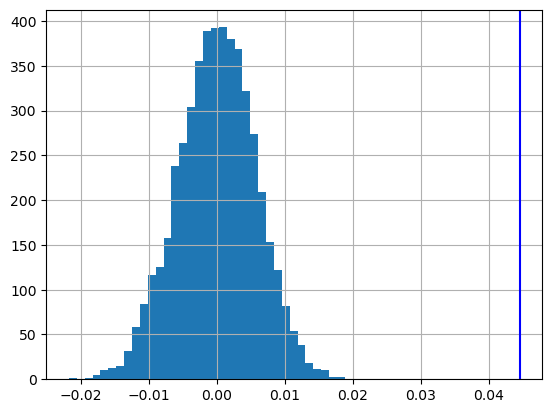

In [55]:
# White Reality Check

predict = best_model.predict(X_test)

positions2 = np.where(predict > 0, 1, -1)

detrended_retFut1 = detrendPrice(Y_test)

# Convert positions2 into a Series with the same index as detrended_retFut1
positions_series = pd.Series(data=positions2, index=detrended_retFut1.index)

# Broadcast positions2 to all columns of detrended_retFut1 (row-wise multiplication)
detrended_syst_rets = detrended_retFut1.mul(positions_series, axis=0)

bootstrap(detrended_syst_rets)


In [56]:
# Monte Carlo Permutation

num_permutations = 1000
permutation_means = np.zeros(num_permutations)
ori_perdictions = best_model.predict(X_test)
position = np.where(ori_perdictions>0, 1,-1)
ori_return = position*Y_test
ori_mean_return = ori_return.mean()

count = 0
for i in range(num_permutations):
    permute = np.random.permutation(X_test)
    predictions = best_model.predict(permute)
    positions = np.where(predictions > 0, 1, -1)
    permutation_return = positions*Y_test
    permutation_means[i] = permutation_return.mean()
    if permutation_means[i] > ori_mean_return:
        count+=1

p_val = (count+1)/(num_permutations+1)
p_val

0.005994005994005994

## 7.4.Plot the Training and Testing Curve

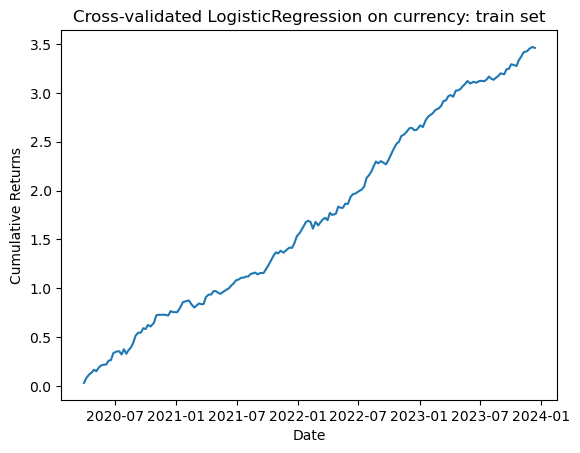

In [59]:
# Train set
# Make "predictions" on training set (in-sample)
#positions = np.where(best_model.predict(x_train)> 0,1,-1 )
positions = np.where(best_model.predict(X_train)> 0,1,-1 ) #POSITIONS

#dailyRet = pd.Series(positions).shift(1).fillna(0).values * x_train.ret1 #for trading at the close
syst_return = pd.Series(positions).fillna(0).values * Y_train #for trading right after the open

syst_return = syst_return.fillna(0)

cumret = np.cumsum(syst_return)


plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated LogisticRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')

plt.show()

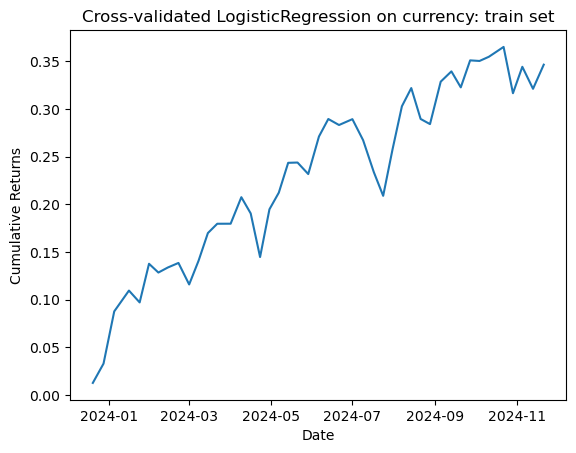

In [62]:
# Train set
# Make "predictions" on training set (in-sample)
#positions = np.where(best_model.predict(x_train)> 0,1,-1 )
positions = np.where(best_model.predict(X_test)> 0,1,-1 ) #POSITIONS

#dailyRet = pd.Series(positions).shift(1).fillna(0).values * x_train.ret1 #for trading at the close
syst_return = pd.Series(positions).fillna(0).values * Y_test #for trading right after the open

syst_return = syst_return.fillna(0)

cumret = np.cumsum(syst_return)


plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated LogisticRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')

plt.show()

After tuning the model and picking the best ARIMA model or the order 2,0 and 1 we select this model and can it can be used for the modeling purpose.

<a id='6.2'></a>
## 7.2. Save Model for Later Use

In [56]:
# Import the required methods from pickle
from pickle import dump, load

# Specify the filename
filename = 'best_model.sav'

# Save the model to disk
dump(best_model, open(filename, 'wb'))
print(f"Model saved as {filename}")


Model saved as best_model.sav


In [57]:
# Load the saved model from disk
loaded_model = load(open('best_model.sav', 'rb'))

# Verify the loaded model
print(f"Model loaded: {loaded_model}")


Model loaded: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.85)),
                ('etr',
                 ExtraTreesRegressor(max_depth=5, min_samples_split=5,
                                     n_estimators=200, random_state=42))])


### Summary

We can conclude that simple models - linear regression, regularized regression (i.e.
Lasso and elastic net) - along with the time series model such as ARIMA are promis‐
ing modelling approaches for asset price prediction problem. These models can
enable financial practitioners to model time dependencies with a very flexible
approach. The overall approach presented in this case study may help us encounter
overfitting and underfitting which are some of the key challenges in the prediction
problem in finance.
We should also note that we can use better set of indicators, such as P/E ratio, trading
volume, technical indicators or news data, which might lead to better results. We will
demonstrate this in some of the case studies in the book.
Overall, we created a supervised-regression and time series modelling framework
which allows us to perform asset class prediction using historical data to generate
results and analyze risk and profitability before risking any actual capital.